Quantized Transfer Learning for Computer Vision Tutorial
========================================================

**Author**: [Zafar Takhirov](https://github.com/z-a-f)

**Reviewed by**: [Raghuraman Krishnamoorthi](https://github.com/raghuramank100)

**Edited by**: [Jessica Lin](https://github.com/jlin27)

This tutorial builds on the original [PyTorch Transfer Learning](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
tutorial, written by [Sasank Chilamkurthy](https://chsasank.github.io/).
Transfer learning refers to techniques that make use of a pretrained model for
application on a different data-set.
There are two main ways the transfer learning is used:
1. **ConvNet as a fixed feature extractor**: Here, you ["freeze"](https://arxiv.org/abs/1706.04983)
   the weights of all the parameters in the network except that of the final
   several layers (aka “the head”, usually fully connected layers).
   These last layers are replaced with new ones initialized with random
   weights and only these layers are trained.
2. **Finetuning the ConvNet**: Instead of random initializaion, the model is
   initialized using a pretrained network, after which the training proceeds as
   usual but with a different dataset.
   Usually the head (or part of it) is also replaced in the network in
   case there is a different number of outputs.
   It is common in this method to set the learning rate to a smaller number.
   This is done because the network is already trained, and only minor changes
   are required to "finetune" it to a new dataset.
   
You can also combine the above two methods:
First you can freeze the feature extractor, and train the head. After
that, you can unfreeze the feature extractor (or part of it), set the
learning rate to something smaller, and continue training.

In this part you will use the first method – extracting the features
using a quantized model.

Part 0. Prerequisites
---------------------
Before diving into the transfer learning, let us review the "prerequisites",
such as installations and data loading/visualizations.

In [1]:
# Imports
import copy
import matplotlib.pyplot as plt
import numpy as np
import os
import time

plt.ion()

### Installing the Nightly Build

Because you will be using the experimental parts of the PyTorch, it is
recommended to install the latest version of ``torch`` and
``torchvision``. You can find the most recent instructions on local
installation [here](https://pytorch.org/get-started/locally/).
For example, to install without GPU support:

```shell
   pip install numpy
   pip install --pre torch torchvision -f https://download.pytorch.org/whl/nightly/cpu/torch_nightly.html
   # For CUDA support use https://download.pytorch.org/whl/nightly/cu101/torch_nightly.html
```

In [2]:
!yes y | pip uninstall torch torchvision
!yes y | pip install --pre torch torchvision -f https://download.pytorch.org/whl/nightly/cu101/torch_nightly.html

Uninstalling torch-1.6.0+cu101:
  Would remove:
    /usr/local/bin/convert-caffe2-to-onnx
    /usr/local/bin/convert-onnx-to-caffe2
    /usr/local/lib/python3.6/dist-packages/caffe2/*
    /usr/local/lib/python3.6/dist-packages/torch-1.6.0+cu101.dist-info/*
    /usr/local/lib/python3.6/dist-packages/torch/*
Proceed (y/n)? y
  Successfully uninstalled torch-1.6.0+cu101
Uninstalling torchvision-0.7.0+cu101:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/torchvision-0.7.0+cu101.dist-info/*
    /usr/local/lib/python3.6/dist-packages/torchvision/*
Proceed (y/n)?   Successfully uninstalled torchvision-0.7.0+cu101
Looking in links: https://download.pytorch.org/whl/nightly/cu101/torch_nightly.html
     |████████████████████████████████| 758.3MB 23kB/s 
     |████████████████████████████████| 12.9MB 22.9MB/s 


### Load Data

**Note:** This section is identical to the original transfer learning tutorial.
We will use ``torchvision`` and ``torch.utils.data`` packages to load
the data.

The problem you are going to solve today is classifying **ants** and
**bees** from images. The dataset contains about 120 training images
each for ants and bees. There are 75 validation images for each class.
This is considered a very small dataset to generalize on. However, since
we are using transfer learning, we should be able to generalize
reasonably well.

*This dataset is a very small subset of imagenet.*

**Note:** Download the data from [here](https://download.pytorch.org/tutorial/hymenoptera_data.zip)
  and extract it to the ``data`` directory. 


In [3]:
import requests
import os
import zipfile

DATA_URL = 'https://download.pytorch.org/tutorial/hymenoptera_data.zip'
DATA_PATH = os.path.join('.', 'data')
FILE_NAME = os.path.join(DATA_PATH, 'hymenoptera_data.zip')

if not os.path.isfile(FILE_NAME):
  print("Downloading the data...")
  os.makedirs('data', exist_ok=True)
  with requests.get(DATA_URL) as req:
    with open(FILE_NAME, 'wb') as f:
      f.write(req.content)
  if 200 <= req.status_code < 300:
    print("Download complete!")
  else:
    print("Download failed!")
else:
  print(FILE_NAME, "already exists, skipping download...")

with zipfile.ZipFile(FILE_NAME, 'r') as zip_ref:
  print("Unzipping...")
  zip_ref.extractall('data')

DATA_PATH = os.path.join(DATA_PATH, 'hymenoptera_data')

Download complete!
Unzipping...


In [4]:
import torch
from torchvision import transforms, datasets

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                              shuffle=True, num_workers=8)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Visualize a few images


Let's visualize a few training images so as to understand the data
augmentations.



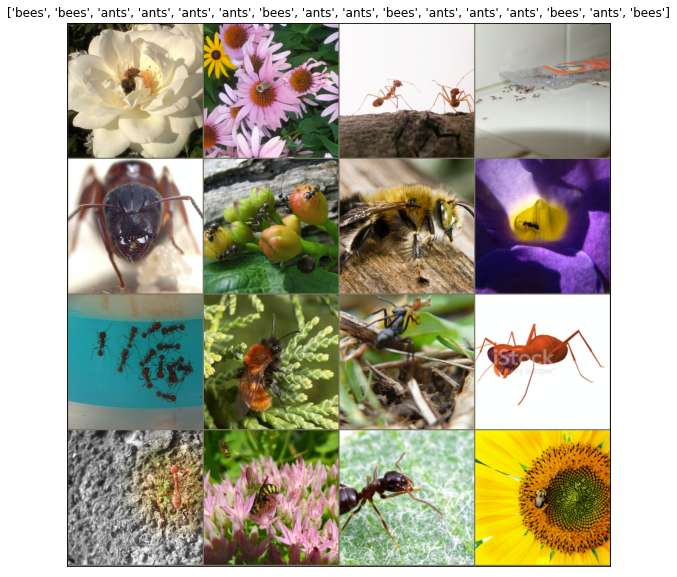

In [5]:
import torchvision

def imshow(inp, title=None, ax=None, figsize=(5, 5)):
  """Imshow for Tensor."""
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  if ax is None:
    fig, ax = plt.subplots(1, figsize=figsize)
  ax.imshow(inp)
  ax.set_xticks([])
  ax.set_yticks([])
  if title is not None:
    ax.set_title(title)

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=4)

fig, ax = plt.subplots(1, figsize=(10, 10))
imshow(out, title=[class_names[x] for x in classes], ax=ax)

### Support Function for Model Training

Below is a generic function for model training.
This function also

- Schedules the learning rate
- Saves the best model



In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, device='cpu'):
      """
      Support function for model training.

      Args:
        model: Model to be trained
        criterion: Optimization criterion (loss)
        optimizer: Optimizer to use for training
        scheduler: Instance of ``torch.optim.lr_scheduler``
        num_epochs: Number of epochs
        device: Device to run the training on. Must be 'cpu' or 'cuda'
      """
      since = time.time()

      best_model_wts = copy.deepcopy(model.state_dict())
      best_acc = 0.0

      for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
          if phase == 'train':
            model.train()  # Set model to training mode
          else:
            model.eval()   # Set model to evaluate mode

          running_loss = 0.0
          running_corrects = 0

          # Iterate over data.
          for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)

              # backward + optimize only if in training phase
              if phase == 'train':
                loss.backward()
                optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
          if phase == 'train':
            scheduler.step()

          epoch_loss = running_loss / dataset_sizes[phase]
          epoch_acc = running_corrects.double() / dataset_sizes[phase]

          print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            phase, epoch_loss, epoch_acc))

          # deep copy the model
          if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        print()

      time_elapsed = time.time() - since
      print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
      print('Best val Acc: {:4f}'.format(best_acc))

      # load best model weights
      model.load_state_dict(best_model_wts)
      return model

### Support Function for Visualizing the Model Predictions

Generic function to display predictions for a few images




In [7]:
 def visualize_model(model, rows=3, cols=3):
      was_training = model.training
      model.eval()
      current_row = current_col = 0
      fig, ax = plt.subplots(rows, cols, figsize=(cols*2, rows*2))

      with torch.no_grad():
        for idx, (imgs, lbls) in enumerate(dataloaders['val']):
          imgs = imgs.cpu()
          lbls = lbls.cpu()

          outputs = model(imgs)
          _, preds = torch.max(outputs, 1)

          for jdx in range(imgs.size()[0]):
            imshow(imgs.data[jdx], ax=ax[current_row, current_col])
            ax[current_row, current_col].axis('off')
            ax[current_row, current_col].set_title('predicted: {}'.format(class_names[preds[jdx]]))

            current_col += 1
            if current_col >= cols:
              current_row += 1
              current_col = 0
            if current_row >= rows:
              model.train(mode=was_training)
              return
        model.train(mode=was_training)


## Part 1. Training a Custom Classifier based on a Quantized Feature Extractor 

In this section you will use a “frozen” quantized feature extractor, and
train a custom classifier head on top of it. Unlike floating point
models, you don’t need to set requires_grad=False for the quantized
model, as it has no trainable parameters. Please, refer to the[documentation](https://pytorch.org/docs/stable/quantization.html) for
more details.

Load a pretrained model: for this exercise you will be using [ResNet-18](https://pytorch.org/hub/pytorch_vision_resnet/).



In [8]:
import torchvision.models.quantization as models

# We will need the number of filters in the `fc` for future use.
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_fe = models.resnet18(pretrained=True, progress=True, quantize=True)
num_ftrs = model_fe.fc.in_features

/usr/local/lib/python3.6/dist-packages/torch/quantization/observer.py:123: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  reduce_range will be deprecated in a future release of PyTorch."
Downloading: "https://download.pytorch.org/models/quantized/resnet18_fbgemm_16fa66dd.pth" to /root/.cache/torch/hub/checkpoints/resnet18_fbgemm_16fa66dd.pth


At this point you need to modify the pretrained model. The model
has the quantize/dequantize blocks in the beginning and the end. However,
because you will only use the feature extractor, the dequantizatioin layer has
to move right before the linear layer (the head). The easiest way to do that
is to wrap the model in the ``nn.Sequential`` module.

The first step is to isolate the feature extractor in the ResNet
model. Although in this example you are tasked to use all layers except
``fc`` as the feature extractor, in reality, you can take as many parts
as you need. This would be useful in case you would like to replace some
of the convolutional layers as well.

**Note:** When separating the feature extractor from the rest of a quantized
   model, you have to manually place the quantizer/dequantized in the
   beginning and the end of the parts you want to keep quantized.

The function below creates a model with a custom head.

In [9]:
from torch import nn

def create_combined_model(model_fe):
  # Step 1. Isolate the feature extractor.
  model_fe_features = nn.Sequential(
    model_fe.quant,  # Quantize the input
    model_fe.conv1,
    model_fe.bn1,
    model_fe.relu,
    model_fe.maxpool,
    model_fe.layer1,
    model_fe.layer2,
    model_fe.layer3,
    model_fe.layer4,
    model_fe.avgpool,
    model_fe.dequant,  # Dequantize the output
  )

  # Step 2. Create a new "head"
  new_head = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(num_ftrs, 2),
  )

  # Step 3. Combine, and don't forget the quant stubs.
  new_model = nn.Sequential(
    model_fe_features,
    nn.Flatten(1),
    new_head,
  )
  return new_model


**Warning:** Currently the quantized models can only be run on CPU.
  However, it is possible to send the non-quantized parts of the model to a GPU.

In [10]:
import torch.optim as optim
new_model = create_combined_model(model_fe)
new_model = new_model.to('cpu')

criterion = nn.CrossEntropyLoss()

# Note that we are only training the head.
optimizer_ft = optim.SGD(new_model.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### Train and evaluate

This step takes around 15-25 min on CPU. Because the quantized model can
only run on the CPU, you cannot run the training on GPU.


In [11]:
new_model = train_model(new_model, criterion, optimizer_ft, exp_lr_scheduler,
                        num_epochs=25, device='cpu')

Epoch 0/24
----------
train Loss: 0.7036 Acc: 0.7459
val Loss: 0.1853 Acc: 0.9412

Epoch 1/24
----------
train Loss: 0.5560 Acc: 0.8607
val Loss: 0.2062 Acc: 0.9542

Epoch 2/24
----------
train Loss: 0.6744 Acc: 0.9057
val Loss: 0.2202 Acc: 0.9673

Epoch 3/24
----------
train Loss: 0.3388 Acc: 0.9303
val Loss: 0.2753 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.4526 Acc: 0.9098
val Loss: 0.5646 Acc: 0.9020

Epoch 5/24
----------
train Loss: 0.4649 Acc: 0.9180
val Loss: 0.4355 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.3631 Acc: 0.9344
val Loss: 0.6949 Acc: 0.8889

Epoch 7/24
----------
train Loss: 0.4639 Acc: 0.9221
val Loss: 0.4078 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.2498 Acc: 0.9385
val Loss: 0.4039 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3054 Acc: 0.9385
val Loss: 0.3961 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.1609 Acc: 0.9631
val Loss: 0.3918 Acc: 0.9542

Epoch 11/24
----------
train Loss: 0.2487 Acc: 0.9549
val Loss: 0.3935 Acc: 0.9346

Ep

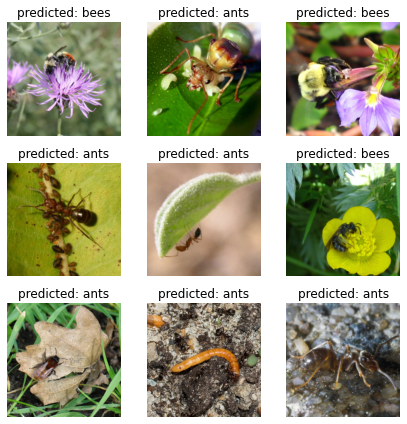

In [12]:
visualize_model(new_model)
plt.tight_layout()

## Part 2. Finetuning the Quantizable Model


In this part, we fine tune the feature extractor used for transfer
learning, and quantize the feature extractor. Note that in both part 1
and 2, the feature extractor is quantized. The difference is that in
part 1, we use a pretrained quantized model. In this part, we create a
quantized feature extractor after fine tuning on the data-set of
interest, so this is a way to get better accuracy with transfer learning
while having the benefits of quantization. Note that in our specific
example, the training set is really small (120 images) so the benefits
of fine tuning the entire model is not apparent. However, the procedure
shown here will improve accuracy for transfer learning with larger
datasets.

The pretrained feature extractor must be quantizable.
To make sure it is quantizable, perform the following steps:

 1. Fuse ``(Conv, BN, ReLU)``, ``(Conv, BN)``, and ``(Conv, ReLU)`` using
    ``torch.quantization.fuse_modules``.
 2. Connect the feature extractor with a custom head.
    This requires dequantizing the output of the feature extractor.
 3. Insert fake-quantization modules at appropriate locations
    in the feature extractor to mimic quantization during training.

For step (1), we use models from ``torchvision/models/quantization``, which
have a member method ``fuse_model``. This function fuses all the ``conv``,
``bn``, and ``relu`` modules. For custom models, this would require calling
the ``torch.quantization.fuse_modules`` API with the list of modules to fuse
manually.

Step (2) is performed by the ``create_combined_model`` function
used in the previous section.

Step (3) is achieved by using ``torch.quantization.prepare_qat``, which
inserts fake-quantization modules.


As step (4), you can start "finetuning" the model, and after that convert
it to a fully quantized version (Step 5).

To convert the fine tuned model into a quantized model you can call the
``torch.quantization.convert`` function (in our case only
the feature extractor is quantized).

**Note:** Because of the random initialization your results might differ from
   the results shown in this tutorial.

In [13]:
# notice `quantize=False`
model = models.resnet18(pretrained=True, progress=True, quantize=False)
num_ftrs = model.fc.in_features

# Step 1
model.train()
model.fuse_model()
# Step 2
model_ft = create_combined_model(model)
model_ft[0].qconfig = torch.quantization.default_qat_qconfig  # Use default QAT configuration
# Step 3
model_ft = torch.quantization.prepare_qat(model_ft, inplace=True)



Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


/usr/local/lib/python3.6/dist-packages/torch/quantization/observer.py:123: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  reduce_range will be deprecated in a future release of PyTorch."


### Finetuning the model

In the current tutorial the whole model is fine tuned. In
general, this will lead to higher accuracy. However, due to the small
training set used here, we end up overfitting to the training set.


Step 4. Fine tune the model


In [14]:
for param in model_ft.parameters():
  param.requires_grad = True

model_ft.to(device)  # We can fine-tune on GPU if available

criterion = nn.CrossEntropyLoss()

# Note that we are training everything, so the learning rate is lower
# Notice the smaller learning rate
optimizer_ft = optim.SGD(model_ft.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.1)

# Decay LR by a factor of 0.3 every several epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.3)

model_ft_tuned = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                              num_epochs=25, device=device)

Epoch 0/24
----------
train Loss: 0.7024 Acc: 0.6025
val Loss: 0.3143 Acc: 0.9085

Epoch 1/24
----------
train Loss: 0.2835 Acc: 0.8770
val Loss: 0.2205 Acc: 0.9281

Epoch 2/24
----------
train Loss: 0.2117 Acc: 0.9057
val Loss: 0.1995 Acc: 0.9216

Epoch 3/24
----------
train Loss: 0.2292 Acc: 0.9098
val Loss: 0.2006 Acc: 0.9150

Epoch 4/24
----------
train Loss: 0.2582 Acc: 0.8975
val Loss: 0.1959 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.1255 Acc: 0.9508
val Loss: 0.1818 Acc: 0.9346

Epoch 6/24
----------
train Loss: 0.0546 Acc: 0.9877
val Loss: 0.1944 Acc: 0.9216

Epoch 7/24
----------
train Loss: 0.0842 Acc: 0.9713
val Loss: 0.1815 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.0907 Acc: 0.9713
val Loss: 0.1715 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.0650 Acc: 0.9795
val Loss: 0.2071 Acc: 0.9085

Epoch 10/24
----------
train Loss: 0.1242 Acc: 0.9508
val Loss: 0.1784 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.0787 Acc: 0.9877
val Loss: 0.1778 Acc: 0.9346

Ep

Step 5. Convert to quantized model


In [15]:
from torch.quantization import convert
model_ft_tuned.cpu()

model_quantized_and_trained = convert(model_ft_tuned, inplace=False)


Lets see how the quantized model performs on a few images


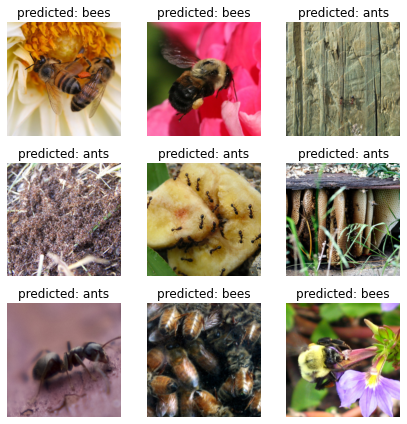

In [16]:
visualize_model(model_quantized_and_trained)

plt.ioff()
plt.tight_layout()
plt.show()